# A

In [21]:
import pandas as pd
import os

def process_results(path_suffix):
    name = ['1', '2', '3', '4', '5']
    merged_dict = {}
    for i in name:
        dataframes = {
            'ERGO_lstm': pd.read_csv(f"./ERGO/result/pair300/seen/{path_suffix}/{i}_1_1lstm_all_result.csv"),
            'ERGO_AE': pd.read_csv(f"./ERGO/result/pair300/seen/{path_suffix}/{i}_1_1ae_all_result.csv"),
            'NetTCR': pd.read_csv(f"./NetTCR/result/pair300/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'DLpTCR_CNN': pd.read_csv(f"./DLpTCR/result/pair300/seen/{path_suffix}/{i}_1_1CNN_pca20_all_result.csv"),
            'DLpTCR_FULL': pd.read_csv(f"./DLpTCR/result/pair300/seen/{path_suffix}/{i}_1_1FULL_pca18_all_result.csv"),
            'DLpTCR_RESNET': pd.read_csv(f"./DLpTCR/result/pair300/seen/{path_suffix}/{i}_1_1RESNET_pca10_all_result.csv"),
            'AttnTAP': pd.read_csv(f"./AttnTAP/result/pair300/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'ATM_TCR': pd.read_csv(f"./ATM_TCR/result/pair300/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'TEINet': pd.read_csv(f"./TEINet/result/pair300/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'epiTCR': pd.read_csv(f"./epiTCR/result/pair300/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'TCR_BERT': pd.read_csv(f"./tcr_bert/result/pair300/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'TCRGP': pd.read_csv(f"./TCRGP/result/pair300/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'SETE': pd.read_csv(f"./SETE/result/pair300/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'TEIM': pd.read_csv(f"./TEIM/result/pair300/seen/{path_suffix}/{i}_1_1all_result.csv"),
            'TPBTE': pd.read_csv(f"./TPBTE/result/pair300/seen/{path_suffix}/{i}_1_1all_result.csv"),
        }

        merged = pd.DataFrame()
        for df_name, df in dataframes.items():
            last_row = df.tail(1)
            last_row.index = [df_name] 
            merged = pd.concat([merged, last_row])
        merged = merged.iloc[:, 1:] 
        merged_dict[f'merged{i}'] = merged
    merged1, merged2, merged3, merged4, merged5 = (merged_dict[f'merged{i}'] for i in name)
    df_mean = (merged1 + merged2 + merged3 + merged4 + merged5) / 5
    new_column_names = {
        'roc_auc': 'AUROC', 'prc_auc': 'AUPRC', 'accuracy': 'Accuracy',
        'precision': 'Precision', 'recall': 'Recall', 'specificity': 'Specificity',
        'mcc': 'MCC', 'f1': 'F1'}
    df_mean.rename(columns=new_column_names, inplace=True)
    df_std = pd.concat([merged1, merged2, merged3, merged4, merged5]).groupby(level=0).std()
    new_column_names_std = {
        'roc_auc': 'AUROC_std', 'prc_auc': 'AUPRC_std', 'accuracy': 'Accuracy_std',
        'precision': 'Precision_std', 'recall': 'Recall_std', 'specificity': 'Specificity_std',
        'mcc': 'MCC_std', 'f1': 'F1_std'}
    df_std.rename(columns=new_column_names_std, inplace=True)

    df_mean = pd.concat([df_mean, df_std], axis=1)
    all_values = df_mean.sort_values(by='AUPRC', ascending=False)
    all_values.index = all_values.index.str.replace('_', '-')
    new_column_order = [
        'AUROC', 'AUROC_std',
        'AUPRC', 'AUPRC_std',
        'Accuracy', 'Accuracy_std',
        'Precision', 'Precision_std',
        'Recall', 'Recall_std',
        'Specificity', 'Specificity_std',
        'MCC', 'MCC_std',
        'F1', 'F1_std'
    ]
    all_values = all_values[new_column_order]
    all_values = all_values.round(4)
    all_values.rename_axis('models', inplace=True)
    return all_values

def process_model_test(model_name,namel,Dean,suffix):
    ant_file = "./raw_data/antigen_species.csv"
    ant = pd.read_csv(ant_file)
    name = ['1', '2', '3', '4', '5']
    merged_dict = {}
    for i in name:
        df=pd.read_csv(f"./{model_name}/result/pair300/seen/{Dean}/{i}_{suffix}.csv")
        df.rename(columns={'epitope': 'Epitope'}, inplace=True)
        df = pd.merge(df, ant, on='Epitope')
        df = df[['prc_auc', 'antigen_species']]
        df = df.set_index('antigen_species')
        df = df.groupby('antigen_species').mean()
        column_names = {'prc_auc': f'{namel}_prc_auc'}
        df = df.rename(columns=column_names)
        merged_dict[f'merged{i}'] = df

    merged1, merged2, merged3, merged4, merged5 = (merged_dict[f'merged{i}'] for i in name) 
    df_mean = (merged1 + merged2 + merged3 + merged4 + merged5) / 5
    df_mean = df_mean.reindex(sorted(df_mean.columns), axis=1)
    return df_mean

def all_models_result(ratio,Dean,AUPRC_test):
    ERGO_AE = process_model_test('ERGO','ERGO_AE',Dean, f'{ratio}ae_all_result')
    ERGO_lstm = process_model_test('ERGO','ERGO_lstm',Dean, f'{ratio}lstm_all_result')
    NetTCR = process_model_test('NetTCR', 'NetTCR',Dean,f'{ratio}all_result')
    DLpTCR_CNN = process_model_test('DLpTCR', 'DLpTCR_CNN',Dean,f'{ratio}CNN_pca20_all_result')
    DLpTCR_FULL = process_model_test('DLpTCR','DLpTCR_FULL',Dean, f'{ratio}FULL_pca18_all_result')
    DLpTCR_RESNET = process_model_test('DLpTCR','DLpTCR_RESNET',Dean, f'{ratio}RESNET_pca10_all_result')
    AttnTAP = process_model_test('AttnTAP','AttnTAP',Dean, f'{ratio}all_result')
    ATM_TCR = process_model_test('ATM_TCR','ATM_TCR', Dean,f'{ratio}all_result')
    TEINet = process_model_test('TEINet','TEINet',Dean, f'{ratio}all_result')
    epiTCR = process_model_test('epiTCR', 'epiTCR',Dean,f'{ratio}all_result')
    SETE = process_model_test('SETE','SETE',Dean,f'{ratio}all_result')
    TEIM = process_model_test('TEIM','TEIM',Dean, f'{ratio}all_result')
    TPBTE  = process_model_test('TPBTE','TPBTE',Dean, f'{ratio}all_result')
    TCR_BERT  = process_model_test('tcr_bert','TCR_BERT',Dean, f'{ratio}all_result')
    TCRGP  = process_model_test('TCRGP','TCRGP',Dean, f'{ratio}all_result')
    all_data = pd.concat([epiTCR, TEINet, ATM_TCR, AttnTAP,DLpTCR_RESNET,DLpTCR_FULL,DLpTCR_CNN,ERGO_AE,ERGO_lstm,SETE,NetTCR,TPBTE,TEIM,TCR_BERT,TCRGP], axis=1)
    selected = all_data.filter(like='prc_auc')
    selected.columns = [col.replace('_prc_auc', '') for col in selected.columns]
    selected=selected.T
    selected.index = selected.index.str.replace('_', '-', regex=False)
    selected = selected.reindex(AUPRC_test.index)
    selected = selected.iloc[::-1]
    return selected

def plot_scatter(ax, selected_data, title, show_yticks=True):
    colors = sns.color_palette("RdYlBu", n_colors=256)[::-1]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    norm = plt.Normalize(selected_data.min().min(), selected_data.max().max())
    for i, column in enumerate(selected_data.columns):
        x = np.full(selected_data.shape[0], i)
        y = np.arange(selected_data.shape[0])
        sizes = 100 * selected_data[column] / selected_data.max().max()
        color = cmap(norm(selected_data[column]))
        ax.scatter(x, y, s=sizes, color=color)

    ax.set_xticks(np.arange(selected_data.columns.size))
    ax.set_xticklabels(selected_data.columns, rotation=45, ha='right', va='top')
    ax.set_title(title, fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)

    if show_yticks:
        ax.set_yticks(np.arange(selected_data.shape[0]))
        ax.set_yticklabels(selected_data.index)
    else:
        ax.set_yticks([])


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

def generate_heatmap_and_scatterplots(path,data_test, file_name_prefix):
    more300 = all_models_result('1_1',f'more300/{path}' , data_test)
    health_300 = all_models_result('1_1', f'300/{path}', data_test)
    health_200 = all_models_result('1_1', f'200/{path}', data_test)
    health_100 = all_models_result('1_1', f'100/{path}', data_test)
    health_10 = all_models_result('1_1', f'10/{path}', data_test)
 

    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['xtick.labelsize'] = 14  
    plt.rcParams['ytick.labelsize'] = 12 
    colors = sns.color_palette("RdYlBu", n_colors=256)[::-1]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    
    fig, axs = plt.subplots(1, 6, figsize=(13, 3.5), gridspec_kw={'width_ratios': [2, 2, 2,2,2, 3]})  

    plot_scatter(axs[0], more300, '>300', show_yticks=True)
    plot_scatter(axs[1], health_300, '300', show_yticks=False)
    plot_scatter(axs[2], health_200, '200', show_yticks=False)
    plot_scatter(axs[3], health_100, '100', show_yticks=False)
    plot_scatter(axs[4], health_10, '10', show_yticks=False)

    sns.heatmap(data_test, cmap=cmap, vmin=0, annot=True, fmt=".2f", vmax=data_test.max().max(), ax=axs[5], yticklabels=False)
    axs[5].set_xticks(np.arange(0.5, len(data_test.columns)))
    axs[5].set_xticklabels(data_test.columns, fontsize=10, rotation=45, ha='right', va='top')
    axs[5].set_title('AUPRC', fontsize=10)
    axs[5].set_yticklabels([]) 
    axs[5].set_ylabel('') 
    plt.subplots_adjust(wspace=0.05)
    plt.savefig(f"./All_results/fig/fig3s/{file_name_prefix}.pdf", bbox_inches='tight')
    plt.show()


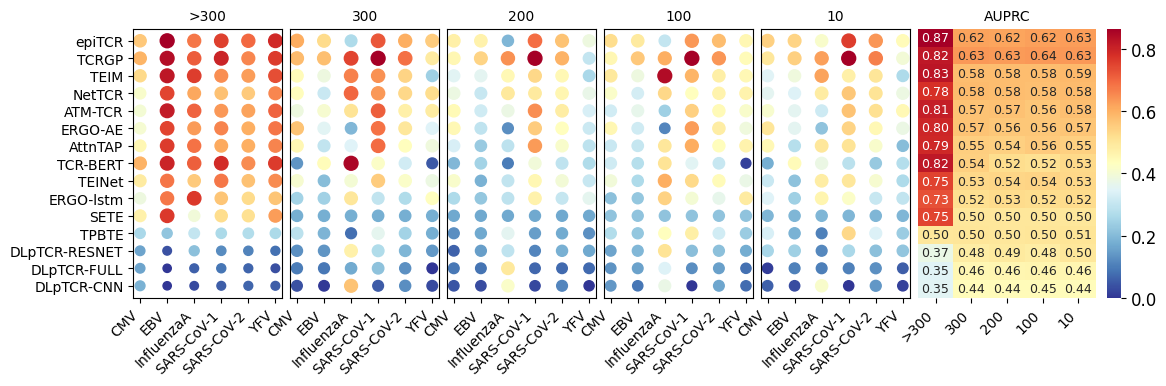

In [22]:
more300=process_results('more300/patient/')
more300.to_csv("./All_results/data/data3/sA_seen_patient_more300.csv")
health_300=process_results('300/patient/')
health_300.to_csv("./All_results/data/data3/sA_seen_patient_300.csv")
health_200=process_results('200/patient/')
health_200.to_csv("./All_results/data/data3/sA_seen_patient_200.csv")
health_100=process_results('100/patient/')
health_100.to_csv("./All_results/data/data3/sA_seen_patient_100.csv")
health_10=process_results('10/patient/')
health_10.to_csv("./All_results/data/data3/sA_seen_patient_10.csv")

desired_index = more300.index
health_300 = health_300.reindex(index=desired_index)
health_200 = health_200.reindex(index=desired_index)
health_100 = health_100.reindex(index=desired_index)
health_10 = health_10.reindex(index=desired_index)

all_data_test = pd.concat([more300['AUPRC'], health_300['AUPRC'], health_200['AUPRC'], health_100['AUPRC'],health_10['AUPRC']], axis=1)
all_data_test.columns = ['>300', '300', '200','100','10']
all_data_test['Mean'] = all_data_test.mean(axis=1)
all_data_test = all_data_test.sort_values(by='Mean', ascending=False)
all_data_test = all_data_test.drop(columns=['Mean'])
generate_heatmap_and_scatterplots('patient', all_data_test, "A_seen_moreTCR_patient")

# B

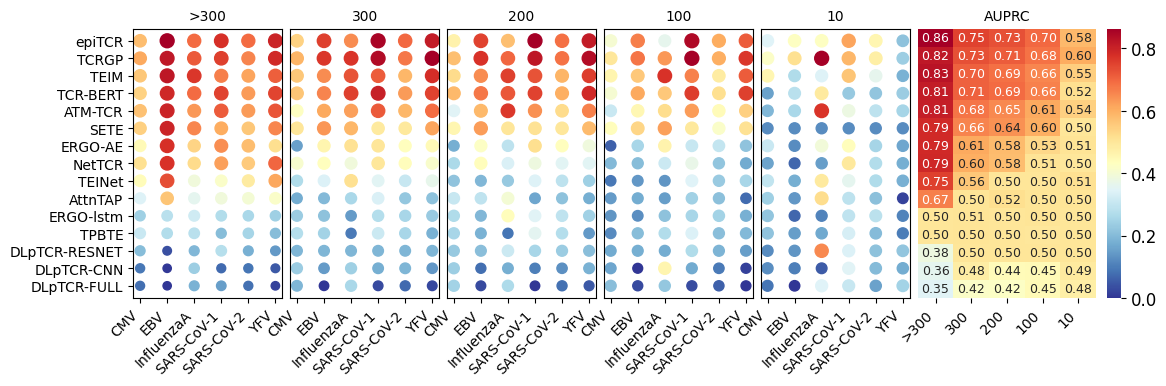

In [23]:
more300=process_results('more300/Antigen_specificity/')
more300.to_csv("./All_results/data/data3/sB_seen_Antigen_specificity_more300.csv")
health_300=process_results('300/Antigen_specificity/')
health_300.to_csv("./All_results/data/data3/sB_seen_Antigen_specificity_300.csv")
health_200=process_results('200/Antigen_specificity/')
health_200.to_csv("./All_results/data/data3/sB_seen_Antigen_specificity_200.csv")
health_100=process_results('100/Antigen_specificity/')
health_100.to_csv("./All_results/data/data3/sB_seen_Antigen_specificity_100.csv")
health_10=process_results('10/Antigen_specificity/')
health_10.to_csv("./All_results/data/data3/sB_seen_Antigen_specificity_10.csv")

desired_index = more300.index
health_300 = health_300.reindex(index=desired_index)
health_200 = health_200.reindex(index=desired_index)
health_100 = health_100.reindex(index=desired_index)
health_10 = health_10.reindex(index=desired_index)

all_data_test = pd.concat([more300['AUPRC'], health_300['AUPRC'], health_200['AUPRC'], health_100['AUPRC'],health_10['AUPRC']], axis=1)
all_data_test.columns = ['>300', '300', '200','100','10']
all_data_test['Mean'] = all_data_test.mean(axis=1)
all_data_test = all_data_test.sort_values(by='Mean', ascending=False)
all_data_test = all_data_test.drop(columns=['Mean'])
generate_heatmap_and_scatterplots('Antigen_specificity', all_data_test, "B_seen_moreTCR_Antigen_specificity")

# D

In [1]:
import os
    
import pandas as pd
def calculate(parameter,name,top1,parameter_name):
    base_path = f"./{name}/result/top5/seen/healthy/"
    n_estimators = parameter
    numbers = ['50', '200', '400', '600', '800', '1000', '1200', '1400', '1600', '1800', '2000', '2200', '2400', '2600', '2800', '3000']
    final_df = pd.DataFrame(index=n_estimators)
    for number in numbers:
        all_means = []
        for estimator in n_estimators:
            file_pattern = f"reap{{}}_{top1}_{number}_{estimator}all_result.csv"
            dfs = [pd.read_csv(f"{base_path}{file_pattern.format(i)}").set_index('epitope') for i in range(1, 6)]
            mean_df = pd.concat(dfs).groupby(level=0).mean()
            prc_auc_mean = mean_df['prc_auc'].mean()  
            all_means.append(prc_auc_mean)
        final_df[number] = all_means
        final_df.index.name =  parameter_name
    return final_df



In [2]:
def plot_heatmaps(final,num,model_name,file_name_prefix,parameter_name):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib.gridspec as gridspec
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['font.size'] = 9
    plt.rcParams['xtick.labelsize'] = 10  
    plt.rcParams['ytick.labelsize'] = 10 
    #colors = ["#AFC8E2", "white", "#EF98A1"]
   # cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    titles = [
        f'Average AUPRC for Different Epitopes ({model_name})',
        'EBV(YVLDHLIVV)',
        'EBV(GLCTLVAML)',
        'SARS-CoV2(FVDGVPFVV)',
        'SARS-CoV2(KLSYGIATV)',
        'SARS-CoV2(FLNGSCGSV)']

    vmin = final.drop(columns='epitope').min().min()
    vmax = final.drop(columns='epitope').max().max()
    n_rows = len(final) // num
    fig = plt.figure(figsize=(9, n_rows * 1.8))
    gs = gridspec.GridSpec(n_rows, 2, width_ratios=[13, 0.5], wspace=0.02)
    axes = []
    for idx in range(n_rows):
        ax = fig.add_subplot(gs[idx, 0])
        axes.append(ax)
        data_segment = final.iloc[idx*5:(idx+1)*5].drop(columns='epitope')
        sns.heatmap(data_segment, cmap='viridis', cbar=False, ax=ax, 
                    yticklabels=data_segment.index, xticklabels=(idx == n_rows - 1), 
                    linewidths=0.5, annot=True, fmt=".3f", vmin=vmin, vmax=vmax)
        ax.set_ylabel(parameter_name)
        ax.set_title(titles[idx], fontsize=10, pad=5)
    cbar_ax = fig.add_subplot(gs[:, 1])
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar_ax.set_position([0.87, 0.4, 0.02, 0.18]) 
    axes[-1].set_xlabel("Number of TCRs", fontsize=10)
    plt.tight_layout(rect=[0, 0, 0.9, 1])  
    plt.savefig(f"./All_results/fig/fig3s/{file_name_prefix}.pdf", bbox_inches='tight')
    plt.show()

/tmp/ipykernel_6267/1246001613.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


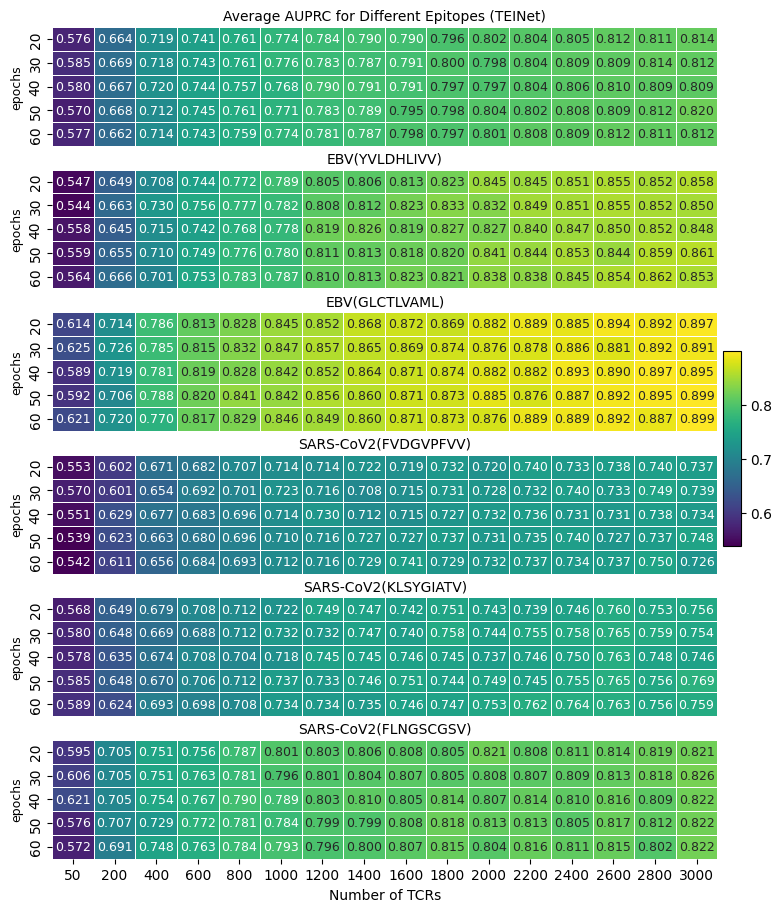

In [3]:
top1= calculate([20, 30, 40, 50, 60],'TEINet','top1','epochs')
top2= calculate([20, 30, 40, 50, 60],'TEINet','top2','epochs')
top3= calculate([20, 30, 40, 50, 60],'TEINet','top3','epochs')
top4= calculate([20, 30, 40, 50, 60],'TEINet','top4','epochs')
top5= calculate([20, 30, 40, 50, 60],'TEINet','top5','epochs')
mean_df = (top1 + top2 + top3 + top4 + top5) / 5
    
top1['epitope']='EBV(YVLDHLIVV)'
top2['epitope']='EBV(GLCTLVAML)'
top3['epitope']='SARS-CoV2(FVDGVPFVV)'
top4['epitope']='SARS-CoV2(KLSYGIATV)'
top5['epitope']='SARS-CoV2(FLNGSCGSV)'

final = pd.concat([top1, top2, top3, top4, top5], axis=0)
final = final.round(4)
final.to_csv("./All_results/data/data3/sD_TEINet_all_parameter.csv")
max_df = final.groupby('epitope').max()
max_df.reset_index(inplace=True)
max_df.to_csv("./All_results/data/data3/C_max_TEINet.csv")

final=pd.concat([mean_df, final], axis=0)
plot_heatmaps(final,5,'TEINet','D_TEINet_all_parameter','epochs')

/tmp/ipykernel_71405/1246001613.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


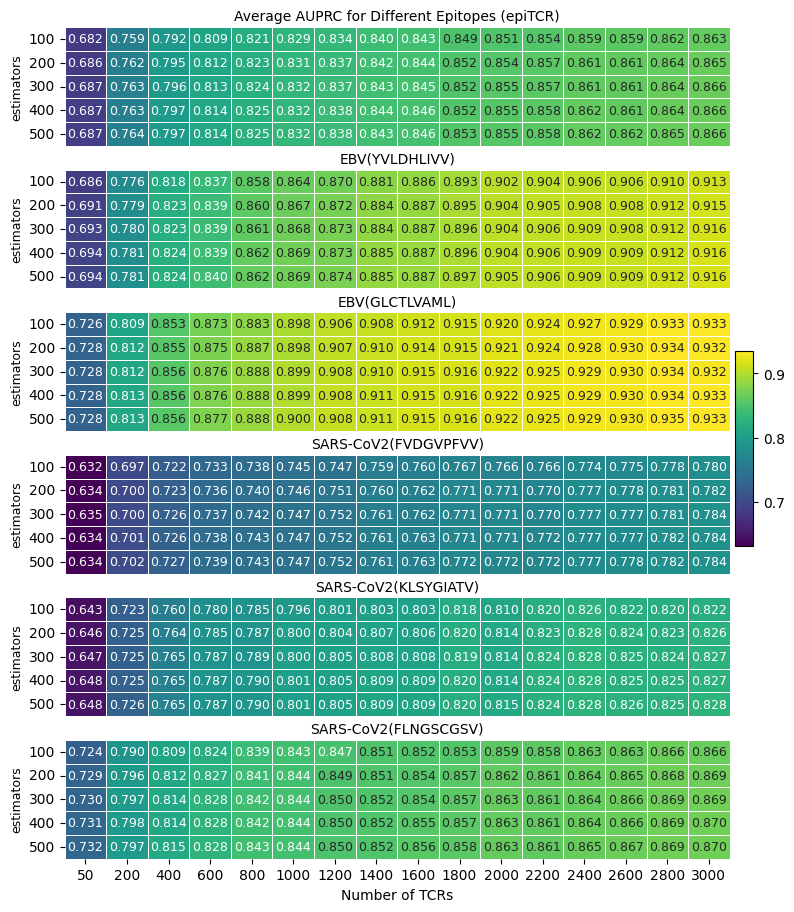

In [113]:
top1= calculate([100, 200, 300, 400, 500],'epiTCR','top1','estimators')
top2= calculate([100, 200, 300, 400, 500],'epiTCR','top2','estimators')
top3= calculate([100, 200, 300, 400, 500],'epiTCR','top3','estimators')
top4= calculate([100, 200, 300, 400, 500],'epiTCR','top4','estimators')
top5= calculate([100, 200, 300, 400, 500],'epiTCR','top5','estimators')
mean_df = (top1 + top2 + top3 + top4 + top5) / 5
mean_df
    
top1['epitope']='EBV(YVLDHLIVV)'
top2['epitope']='EBV(GLCTLVAML)'
top3['epitope']='SARS-CoV2(FVDGVPFVV)'
top4['epitope']='SARS-CoV2(KLSYGIATV)'
top5['epitope']='SARS-CoV2(FLNGSCGSV)'

final = pd.concat([top1, top2, top3, top4, top5], axis=0)
final = final.round(4)
final.to_csv("./All_results/data/data3/sD_epiTCR_all_parameter.csv")
max_df = final.groupby('epitope').max()
max_df.reset_index(inplace=True)
max_df.to_csv("./All_results/data/data3/C_max_epiTCR.csv")


final=pd.concat([mean_df, final], axis=0)
plot_heatmaps(final,5,'epiTCR','D_epiTCR_all_parameter','estimators')

/tmp/ipykernel_71405/1246001613.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


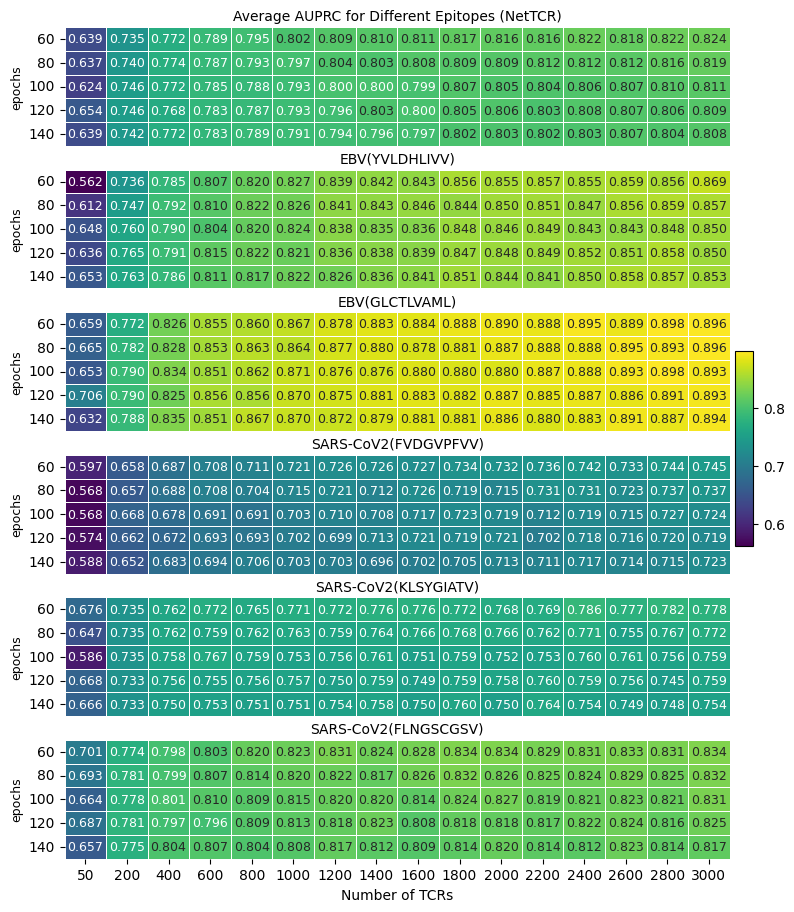

In [114]:
top1= calculate([60,80,100,120,140],'NetTCR','top1','epochs')
top2= calculate([60,80,100,120,140],'NetTCR','top2','epochs')
top3= calculate([60,80,100,120,140],'NetTCR','top3','epochs')
top4= calculate([60,80,100,120,140],'NetTCR','top4','epochs')
top5= calculate([60,80,100,120,140],'NetTCR','top5','epochs')
mean_df = (top1 + top2 + top3 + top4 + top5) / 5
top1['epitope']='EBV(YVLDHLIVV)'
top2['epitope']='EBV(GLCTLVAML)'
top3['epitope']='SARS-CoV2(FVDGVPFVV)'
top4['epitope']='SARS-CoV2(KLSYGIATV)'
top5['epitope']='SARS-CoV2(FLNGSCGSV)'

final = pd.concat([top1, top2, top3, top4, top5], axis=0)
final = final.round(4)
final.to_csv("./All_results/data/data3/sD_NetTCR_all_parameter.csv")
max_df = final.groupby('epitope').max()
max_df.reset_index(inplace=True)
max_df.to_csv("./All_results/data/data3/C_max_NetTCR.csv")

final=pd.concat([mean_df, final], axis=0)
plot_heatmaps(final,5,'NetTCR','D_NetTCR_all_parameter','epochs')

/tmp/ipykernel_71405/1246001613.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


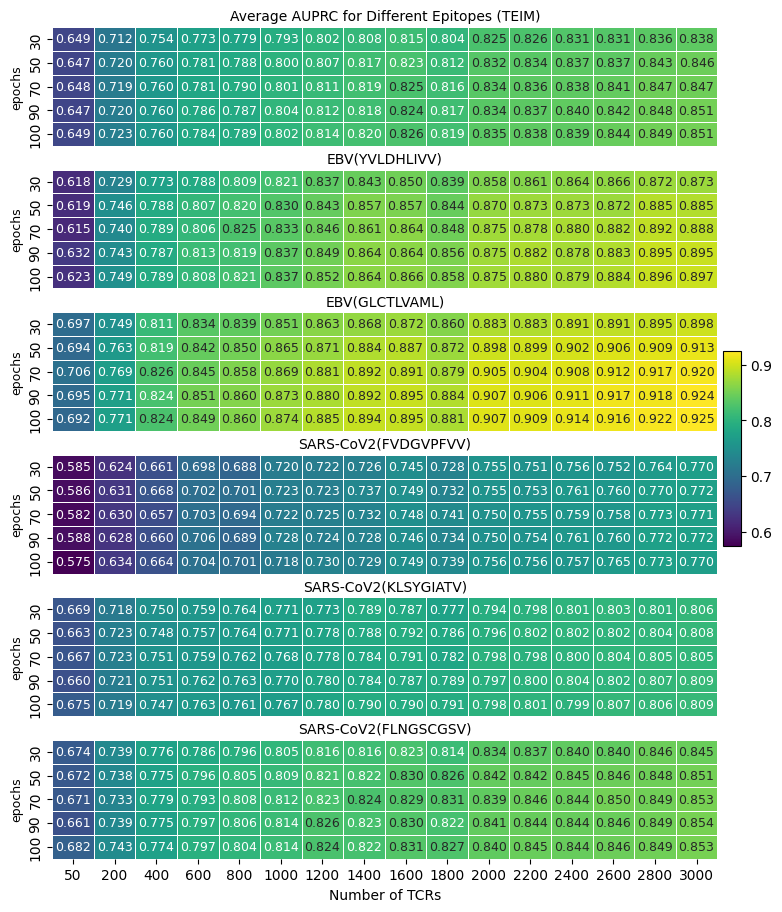

In [130]:
top1= calculate([30,50,70,90,100],'TEIM','top1','epochs')
top2= calculate([30,50,70,90,100],'TEIM','top2','epochs')
top3= calculate([30,50,70,90,100],'TEIM','top3','epochs')
top4= calculate([30,50,70,90,100],'TEIM','top4','epochs')
top5= calculate([30,50,70,90,100],'TEIM','top5','epochs')

mean_df = (top1 + top2 + top3 + top4 + top5) / 5
top1['epitope']='EBV(YVLDHLIVV)'
top2['epitope']='EBV(GLCTLVAML)'
top3['epitope']='SARS-CoV2(FVDGVPFVV)'
top4['epitope']='SARS-CoV2(KLSYGIATV)'
top5['epitope']='SARS-CoV2(FLNGSCGSV)'

final = pd.concat([top1, top2, top3, top4, top5], axis=0)
final = final.round(4)
final.to_csv("./All_results/data/data3/sD_TEIM_all_parameter.csv")
max_df = final.groupby('epitope').max()
max_df.reset_index(inplace=True)
max_df.to_csv("./All_results/data/data3/C_max_TEIM.csv")

final=pd.concat([mean_df, final], axis=0)
plot_heatmaps(final,5,'TEIM','D_TEIM_all_parameter','epochs')

/tmp/ipykernel_71405/1246001613.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


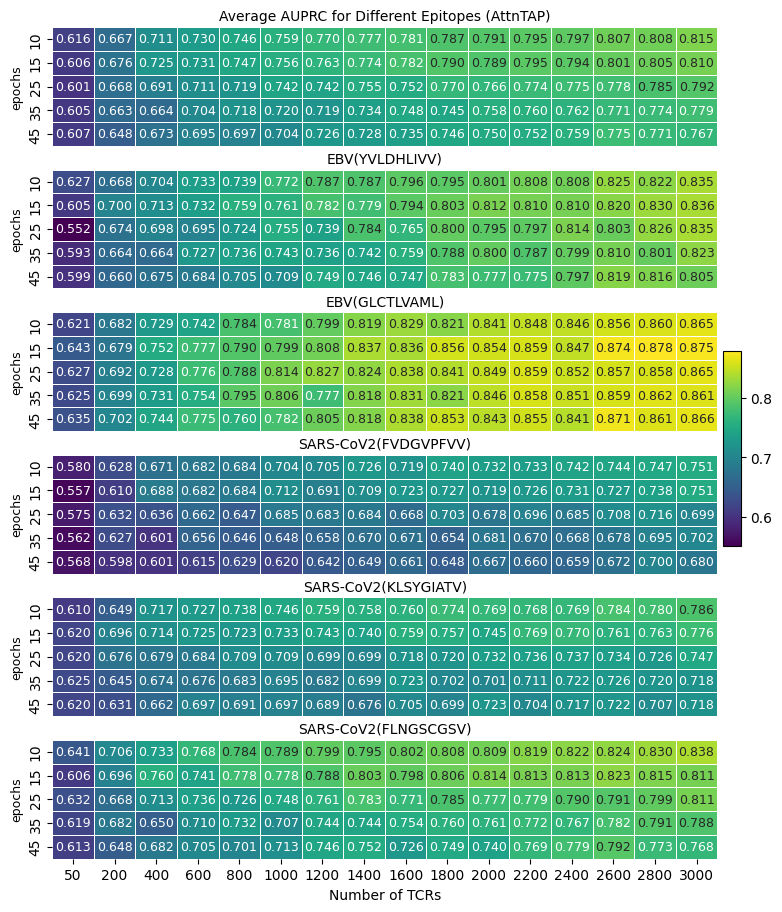

In [139]:
top1= calculate([10,15,25,35,45],'AttnTAP','top1','epochs')
top2= calculate([10,15,25,35,45],'AttnTAP','top2','epochs')
top3= calculate([10,15,25,35,45],'AttnTAP','top3','epochs')
top4= calculate([10,15,25,35,45],'AttnTAP','top4','epochs')
top5= calculate([10,15,25,35,45],'AttnTAP','top5','epochs')

mean_df = (top1 + top2 + top3 + top4 + top5) / 5
top1['epitope']='EBV(YVLDHLIVV)'
top2['epitope']='EBV(GLCTLVAML)'
top3['epitope']='SARS-CoV2(FVDGVPFVV)'
top4['epitope']='SARS-CoV2(KLSYGIATV)'
top5['epitope']='SARS-CoV2(FLNGSCGSV)'

final = pd.concat([top1, top2, top3, top4, top5], axis=0)
final = final.round(4)
final.to_csv("./All_results/data/data3/sD_AttnTAP_all_parameter.csv")
max_df = final.groupby('epitope').max()
max_df.reset_index(inplace=True)
max_df.to_csv("./All_results/data/data3/C_max_AttnTAP.csv")

final=pd.concat([mean_df, final], axis=0)
plot_heatmaps(final,5,'AttnTAP','D_AttnTAP_all_parameter','epochs')

/tmp/ipykernel_1111/1246001613.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


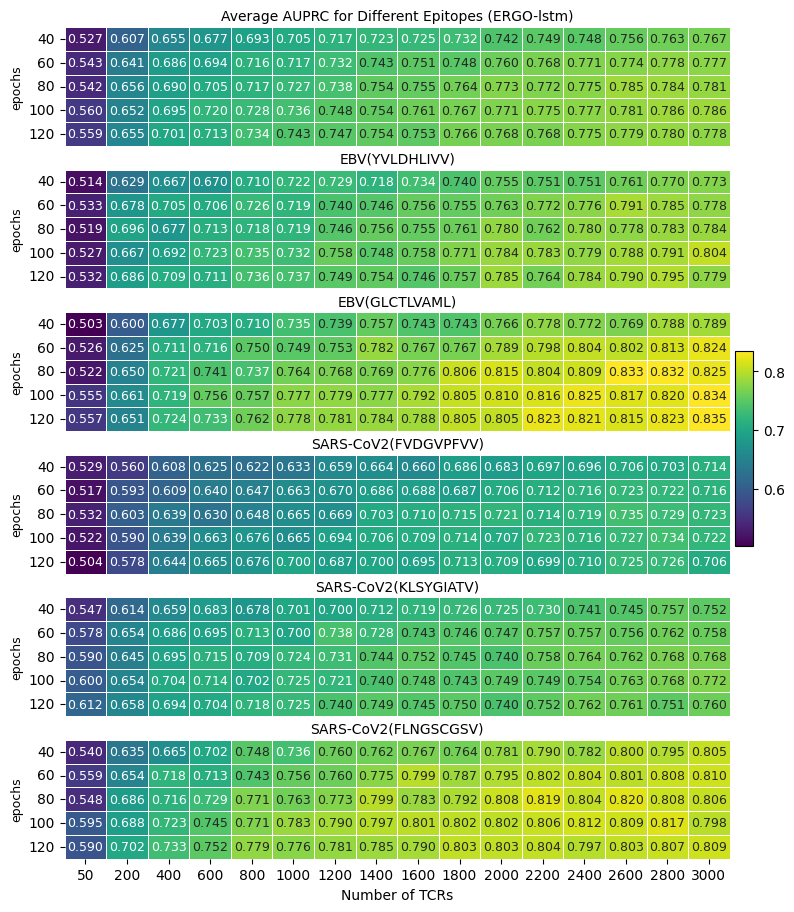

In [3]:
def calculate(parameter,name,top1,parameter_name,all_result):
    base_path = f"./{name}/result/top5/seen/healthy/"
    n_estimators = parameter
    numbers = ['50', '200', '400', '600', '800', '1000', '1200', '1400', '1600', '1800', '2000', '2200', '2400', '2600', '2800', '3000']
    final_df = pd.DataFrame(index=n_estimators)
    for number in numbers:
        all_means = []
        for estimator in n_estimators:
            file_pattern = f"reap{{}}_{top1}_{number}_{estimator}{all_result}.csv"
            dfs = [pd.read_csv(f"{base_path}{file_pattern.format(i)}").set_index('epitope') for i in range(1, 5)]
            mean_df = pd.concat(dfs).groupby(level=0).mean()
            prc_auc_mean = mean_df['prc_auc'].mean()  
            all_means.append(prc_auc_mean)
        final_df[number] = all_means
        final_df.index.name =  parameter_name
    return final_df


top1= calculate([40,60,80,100,120],'ERGO','top1','epochs','_lstm_all_result')
top2= calculate([40,60,80,100,120],'ERGO','top2','epochs','_lstm_all_result')
top3= calculate([40,60,80,100,120],'ERGO','top3','epochs','_lstm_all_result')
top4= calculate([40,60,80,100,120],'ERGO','top4','epochs','_lstm_all_result')
top5= calculate([40,60,80,100,120],'ERGO','top5','epochs','_lstm_all_result')
mean_df = (top1 + top2 + top3 + top4 + top5) / 5
top1['epitope']='EBV(YVLDHLIVV)'
top2['epitope']='EBV(GLCTLVAML)'
top3['epitope']='SARS-CoV2(FVDGVPFVV)'
top4['epitope']='SARS-CoV2(KLSYGIATV)'
top5['epitope']='SARS-CoV2(FLNGSCGSV)'

final = pd.concat([top1, top2, top3, top4, top5], axis=0)
final = final.round(4)
final.to_csv("./All_results/data/data3/sD_ERGO_lstm_all_parameter.csv")
max_df = final.groupby('epitope').max()
max_df.reset_index(inplace=True)
max_df.to_csv("./All_results/data/data3/C_max_ERGO_lstm.csv")

final=pd.concat([mean_df, final], axis=0)
plot_heatmaps(final,5,'ERGO-lstm','D_ERGO_lstm_all_parameter','epochs')

/tmp/ipykernel_6267/1246001613.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


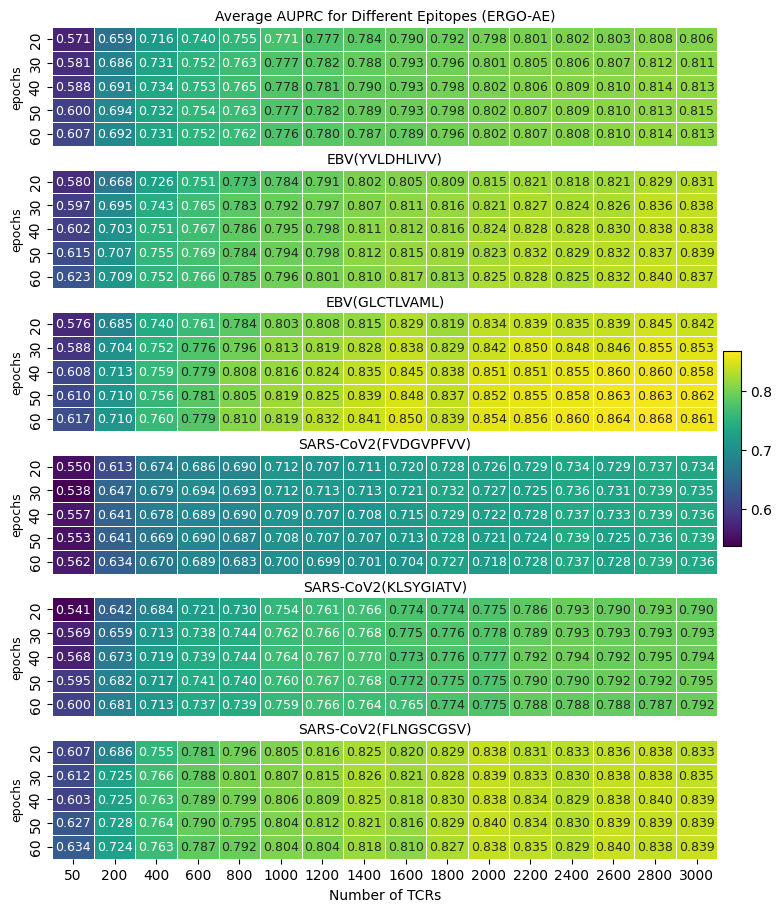

In [7]:
top1= calculate([20,30,40,50,60],'ERGO','top1','epochs','ae_all_result')
top2= calculate([20,30,40,50,60],'ERGO','top2','epochs','ae_all_result')
top3= calculate([20,30,40,50,60],'ERGO','top3','epochs','ae_all_result')
top4= calculate([20,30,40,50,60],'ERGO','top4','epochs','ae_all_result')
top5= calculate([20,30,40,50,60],'ERGO','top5','epochs','ae_all_result')
mean_df = (top1 + top2 + top3 + top4 + top5) / 5
top1['epitope']='EBV(YVLDHLIVV)'
top2['epitope']='EBV(GLCTLVAML)'
top3['epitope']='SARS-CoV2(FVDGVPFVV)'
top4['epitope']='SARS-CoV2(KLSYGIATV)'
top5['epitope']='SARS-CoV2(FLNGSCGSV)'

final = pd.concat([top1, top2, 
                   top3, top4, top5], axis=0)
final = final.round(4)
final.to_csv("./All_results/data/data3/sD_ERGO_ae_all_parameter.csv")
max_df = final.groupby('epitope').max()
max_df.reset_index(inplace=True)
max_df.to_csv("./All_results/data/data3/C_max_ERGO_AE.csv")

final=pd.concat([mean_df, final], axis=0)
plot_heatmaps(final,5,'ERGO-AE','D_ERGO_ae_all_parameter','epochs')

In [9]:
def plot_heatmaps(final,num,model_name,file_name_prefix,parameter_name):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib.gridspec as gridspec
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['font.size'] = 9
    plt.rcParams['xtick.labelsize'] = 10  
    plt.rcParams['ytick.labelsize'] = 10 
    #colors = ["#AFC8E2", "white", "#EF98A1"]
   # cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    titles = [
        f'Average AUPRC for Different Epitopes ({model_name})',
        'EBV(YVLDHLIVV)',
        'EBV(GLCTLVAML)',
        'SARS-CoV2(FVDGVPFVV)',
        'SARS-CoV2(KLSYGIATV)',
        'SARS-CoV2(FLNGSCGSV)']

    vmin = final.drop(columns='epitope').min().min()
    vmax = final.drop(columns='epitope').max().max()
    n_rows = len(final) // num
    fig = plt.figure(figsize=(9, n_rows * 1.8))
    gs = gridspec.GridSpec(n_rows, 2, width_ratios=[13, 0.5], wspace=0.02)
    axes = []
    for idx in range(n_rows):
        ax = fig.add_subplot(gs[idx, 0])
        axes.append(ax)
        data_segment = final.iloc[idx*4:(idx+1)*4].drop(columns='epitope')
        sns.heatmap(data_segment, cmap='viridis', cbar=False, ax=ax, 
                    yticklabels=data_segment.index, xticklabels=(idx == n_rows - 1), 
                    linewidths=0.5, annot=True, fmt=".3f", vmin=vmin, vmax=vmax)
        ax.set_ylabel(parameter_name)
        ax.set_title(titles[idx], fontsize=10, pad=5)
    cbar_ax = fig.add_subplot(gs[:, 1])
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar_ax.set_position([0.87, 0.4, 0.02, 0.18]) 
    axes[-1].set_xlabel("Number of TCRs", fontsize=10)
    plt.tight_layout(rect=[0, 0, 0.9, 1])  
    plt.savefig(f"./All_results/fig/fig3s/{file_name_prefix}.pdf", bbox_inches='tight')
    plt.show()


top1= calculate([50,70,90,100],'ATM_TCR','top1','epochs')
top2= calculate([50,70,90,100],'ATM_TCR','top2','epochs')
top3= calculate([50,70,90,100],'ATM_TCR','top3','epochs')
top4= calculate([50,70,90,100],'ATM_TCR','top4','epochs')
top5= calculate([50,70,90,100],'ATM_TCR','top5','epochs')
mean_df = (top1 + top2 + top3 + top4 + top5) / 5
top1['epitope']='EBV(YVLDHLIVV)'
top2['epitope']='EBV(GLCTLVAML)'
top3['epitope']='SARS-CoV2(FVDGVPFVV)'
top4['epitope']='SARS-CoV2(KLSYGIATV)'
top5['epitope']='SARS-CoV2(FLNGSCGSV)'

final = pd.concat([top1, top2, top3, top4, top5], axis=0)
final = final.round(4)
final.to_csv("./All_results/data/data3/sD_ATM_TCR_all_parameter.csv")
max_df = final.groupby('epitope').max()
max_df.reset_index(inplace=True)
max_df.to_csv("./All_results/data/data3/C_max_ATM_TCR.csv")

final=pd.concat([mean_df, final], axis=0)
plot_heatmaps(final,4,'ATM_TCR','D_ATM_TCR_all_parameter','epochs')

TypeError: calculate() missing 1 required positional argument: 'all_result'

In [5]:
import pandas as pd
def calculate(name, top_range,all_result):
    base_path = f"./{name}/result/top5/seen/healthy/"
    numbers = ['50', '200', '400', '600', '800', '1000', '1200', '1400', '1600', '1800', '2000', '2200', '2400', '2600', '2800', '3000']
    final_df = pd.DataFrame(columns=numbers)
    for top in top_range:
        for number in numbers:
            file_pattern = f"reap{{}}_{top}_{number}{all_result}.csv"
            dfs = [pd.read_csv(f"{base_path}{file_pattern.format(i)}").set_index('epitope') for i in range(1, 6)]
            mean_df = pd.concat(dfs).groupby(level=0).mean()
            prc_auc_mean = mean_df['prc_auc'].mean()  
            final_df.loc[top, number] = prc_auc_mean
    final_df['epitope'] = ['EBV(YVLDHLIVV)', 'EBV(GLCTLVAML)', 'SARS-CoV2(FVDGVPFVV)','SARS-CoV2(KLSYGIATV)', 'SARS-CoV2(FLNGSCGSV)']
    return final_df


In [66]:
top_range = ['top1', 'top2', 'top3', 'top4', 'top5']
SETE = calculate('SETE', top_range,'all_result')
SETE.set_index('epitope', inplace=True)
SETE.reset_index(inplace=True)
SETE.to_csv("./All_results/data/data3/C_max_SETE.csv")

TCRGP = calculate('TCRGP', top_range,'20all_result')
TCRGP.set_index('epitope', inplace=True)
TCRGP.reset_index(inplace=True)
TCRGP.to_csv("./All_results/data/data3/C_max_TCRGP.csv")

tcr_bert = calculate('tcr_bert', top_range,'all_result')
tcr_bert.set_index('epitope', inplace=True)
tcr_bert.reset_index(inplace=True)
tcr_bert.to_csv("./All_results/data/data3/C_max_tcr_bert.csv")

In [6]:

top_range = ['top1', 'top2', 'top3', 'top4', 'top5']
tcr_bert = calculate('tcr_bert', top_range,'all_result')
tcr_bert.set_index('epitope', inplace=True)
tcr_bert.reset_index(inplace=True)
tcr_bert.to_csv("./All_results/data/data3/C_max_tcr_bert.csv")